In [1]:
from openni import openni2
from openni import _openni2 as c_api
import numpy as np
import matplotlib.pyplot as plt
from pyntcloud import PyntCloud as pc

%matplotlib inline

Various setup variables

In [2]:
Depth_ResX = 512
Depth_ResY = 424
Depth_fps = 30
RGB_ResX = 1920
RGB_ResY = 1080
RGB_fps = 30

Initialize OpenNNI

In [3]:
openni2.initialize("/usr/lib")

Open a device, and get some info from it.

In [4]:
dev = openni2.Device.open_any()
print(dev.get_device_info())

OniDeviceInfo(uri = b'freenect2://0?serial=124535140947', vendor = b'Microsoft', name = b'Kinect', usbVendorId = 53776, usbProductId = 36528)


Create a depth stream

In [5]:
#dev.set_image_registration_mode(True)
#dev.get_image_registration_mode()
#dev.depth_color_sync = True
#dev.get_image_registration_mode()
dev.set_depth_color_sync_enabled(True)

In [6]:
depth_stream = dev.create_depth_stream()
depth_stream.set_video_mode(c_api.OniVideoMode(pixelFormat=c_api.OniPixelFormat.ONI_PIXEL_FORMAT_DEPTH_1_MM,
                                               resolutionX=Depth_ResX,
                                               resolutionY=Depth_ResY,
                                               fps=Depth_fps,
                                              ))
depth_sensor_info = depth_stream.get_sensor_info()

Get depth stream video modes

In [7]:
for itm in depth_sensor_info.videoModes:
    print(itm)
max_depth = depth_stream.get_max_pixel_value()
#min_depth = depth_stream.get_min_pixel_value()
min_depth = 0
print("Min depth value: {}".format(min_depth))
print("Max depth value: {}".format(max_depth))

OniVideoMode(pixelFormat = OniPixelFormat.ONI_PIXEL_FORMAT_DEPTH_1_MM, resolutionX = 512, resolutionY = 424, fps = 30)
OniVideoMode(pixelFormat = OniPixelFormat.ONI_PIXEL_FORMAT_DEPTH_1_MM, resolutionX = 640, resolutionY = 480, fps = 30)
Min depth value: 0
Max depth value: 10000


Create color stream

In [8]:
rgb_stream = dev.create_color_stream()
rgb_sensor_info = rgb_stream.get_sensor_info()
for itm in rgb_sensor_info.videoModes:
    print(itm)

rgb_stream.set_video_mode(c_api.OniVideoMode(pixelFormat=c_api.OniPixelFormat.ONI_PIXEL_FORMAT_RGB888,
                                             resolutionX=RGB_ResX,
                                             resolutionY=RGB_ResY,
                                             fps=RGB_fps,
                                            ))

OniVideoMode(pixelFormat = OniPixelFormat.ONI_PIXEL_FORMAT_RGB888, resolutionX = 512, resolutionY = 424, fps = 30)
OniVideoMode(pixelFormat = OniPixelFormat.ONI_PIXEL_FORMAT_RGB888, resolutionX = 1920, resolutionY = 1080, fps = 30)


Start both streams, and get a buffer with data

In [9]:
depth_stream.start()
rgb_stream.start()

depth_frame = depth_stream.read_frame()
depth_data = depth_frame.get_buffer_as_uint16()
rgb_frame = rgb_stream.read_frame()
rgb_data = rgb_frame.get_buffer_as_triplet()

depth_stream.stop()
rgb_stream.stop()

In [10]:
depth_array = np.frombuffer(depth_data, dtype=np.uint16)
print(depth_array.shape)
depth_image = depth_array.reshape(Depth_ResY, Depth_ResX)
print(depth_image.shape)

(217088,)
(424, 512)


In [11]:
depth_image[depth_image==0x0000] = 0 #max_depth
depth_image[depth_image==0x7ff8] = 0
depth_image[depth_image==0xfff8] = 0
max_depth = np.max(depth_image)
depth_image = (depth_image - min_depth) / (max_depth - min_depth)
print(np.min(depth_image))
print(np.max(depth_image))

0.0
1.0


In [12]:
import pandas as pd
df = pd.DataFrame(depth_image.reshape(-1, ))
df.describe()

,0
count,217088.000000
mean,0.210024
std,0.304177
min,0.000000
25%,0.000000
50%,0.000000
75%,0.406000
max,1.000000


In [13]:
color_array = np.frombuffer(rgb_data, dtype=np.uint8)
print(color_array.shape)
color_image = color_array.reshape(RGB_ResY, RGB_ResX, -1)
#color_image = color_array.reshape(Depth_ResY, Depth_ResX, -1)
print(color_image.shape)

(6220800,)
(1080, 1920, 3)


In [14]:
#color_image[depth_image==0] = (0, 0, 0)

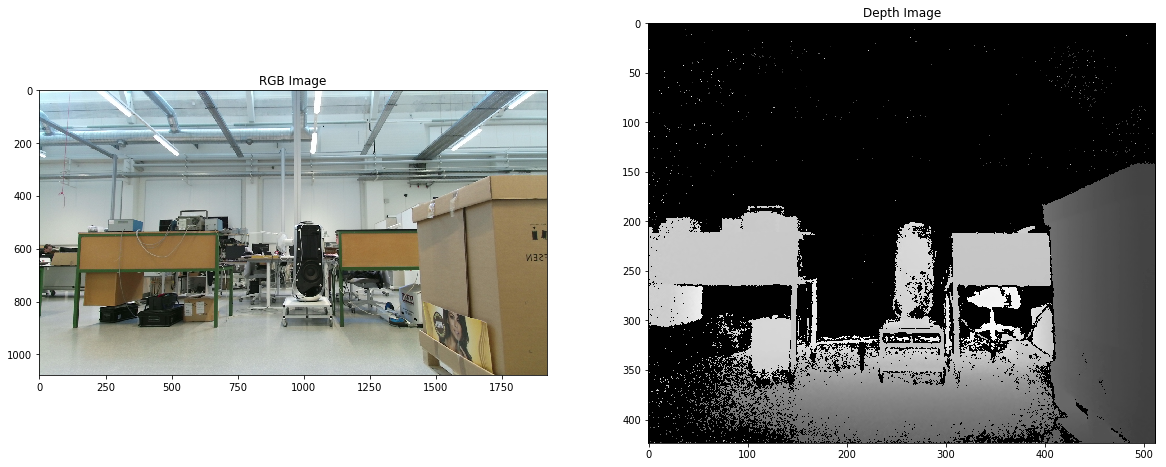

In [15]:
fig, subs = plt.subplots(1, 2, figsize=(20, 8))
subs[0].set_title("RGB Image")
subs[0].imshow(color_image)
subs[1].set_title("Depth Image")
subs[1].imshow(depth_image, cmap='gray')

https://codeyarns.com/2015/09/08/how-to-compute-intrinsic-camera-matrix-for-a-camera/

In [16]:
horiz_fov_rgb = rgb_stream.get_horizontal_fov()
vert_fov_rgb = rgb_stream.get_vertical_fov()
horiz_fov_depth = depth_stream.get_horizontal_fov()
vert_fov_depth = depth_stream.get_vertical_fov()

In [17]:
cx_rgb = int(RGB_ResX / 2)
cy_rgb = int(RGB_ResY / 2)
cx_depth = int(Depth_ResX / 2)
cy_depth = int(Depth_ResY / 2)

In [18]:
fx_rgb = RGB_ResX / np.tan(horiz_fov_rgb/2)
fy_rgb = RGB_ResY / np.tan(vert_fov_rgb/2)
s_rgb = 0.0
print("fx: {}, fy: {}".format(fx_rgb, fy_rgb))

fx: 3195.4167847505364, fy: 2391.934896409577


In [19]:
int_mat_rgb = np.zeros((3, 3))
int_mat_rgb = [[fx_rgb, s_rgb, RGB_ResX],
               [0.0, fy_rgb, RGB_ResY],
               [0.0, 0.0, 1]]
print(int_mat_rgb)

[[3195.4167847505364, 0.0, 1920], [0.0, 2391.934896409577, 1080], [0.0, 0.0, 1]]


In [20]:
fx_depth = Depth_ResX / np.tan(horiz_fov_depth/2)
fy_depth = Depth_ResY / np.tan(vert_fov_depth/2)
s_depth = 0.0

In [21]:
int_mat_depth = [[fx_depth, s_depth, Depth_ResX],
                 [0.0, fy_depth, Depth_ResY],
                 [0.0, 0.0, 1]]
print(int_mat_depth)

[[914.2417217733927, 0.0, 512], [0.0, 1008.6561609067882, 424], [0.0, 0.0, 1]]


https://www.codefull.org/2016/03/align-depth-and-color-frames-depth-and-rgb-registration/

In [71]:
#aligned = np.zeros((Depth_ResY, Depth_ResX, 6))
aligned = np.zeros((Depth_ResY * Depth_ResX, 6))
print(depth_image.shape)
print(aligned.shape)

(424, 512)
(217088, 6)


In [41]:
depth_scale = 1.0

In [91]:
depth_data = depth_image * 255.0
rgb_data = color_image

counter = 0
for v in range(Depth_ResY):
    for u in range(Depth_ResX):
        z_d = int(depth_data[v, u] * depth_scale)
        x_d = int((u - cx_depth) * z_d / fx_depth)
        y_d = int((v - cy_depth) * z_d / fy_depth)
        
        #aligned[v, u, 0:3] = (x_d, y_d, z_d)
        
        #x_rgb = aligned[v, u, 0] * fx_rgb / aligned[v, u, 2] + cx_rgb
        #y_rgb = aligned[v, u, 1] * fy_rgb / aligned[v, u, 2] + cy_rgb
        
        """
        if z_d == 0:
            continue
        
        x_rgb = x_d * fx_rgb / z_d + cx_rgb
        y_rgb = y_d * fy_rgb / z_d + cy_rgb
        
        if x_rgb > RGB_ResX or y_rgb > RGB_ResY or x_rgb < 0 or y_rgb < 0:
            continue
        
        x_rgb = int(x_rgb)
        y_rgb = int(y_rgb)
        
        #print(x_rgb)
        
        #aligned[v, u, 3:6] = color_image[x_rgb, y_rgb, :]
        """
        
        aligned[counter, 0:3] = (x_d, y_d, z_d)
        
        #if not np.isnan(x_rgb) and not np.isnan(y_rgb):
        #aligned[counter, 3:] = color_image[y_rgb, x_rgb]
        
        aligned[counter, 3:] = (128, 128, 128)
        
        counter += 1


In [92]:
points = pd.DataFrame(aligned, columns=['x', 'y', 'z', 'red', 'green', 'blue'])
points.describe()

,x,y,z,red,green,blue
count,217088.000000,217088.000000,217088.000000,217088.0,217088.0,217088.0
mean,0.255132,4.465714,53.370536,128.0,128.0,128.0
std,13.832821,8.101081,77.348672,0.0,0.0,0.0
min,-67.000000,-50.000000,0.000000,128.0,128.0,128.0
25%,0.000000,0.000000,0.000000,128.0,128.0,128.0
50%,0.000000,0.000000,0.000000,128.0,128.0,128.0
75%,0.000000,6.000000,103.000000,128.0,128.0,128.0
max,54.000000,38.000000,255.000000,128.0,128.0,128.0


In [70]:
print(points.isnull().sum())
print()
print(points.isna().sum())

x        0
y        0
z        0
red      0
green    0
blue     0
dtype: int64

x        0
y        0
z        0
red      0
green    0
blue     0
dtype: int64


In [93]:
cloud = pc(points)
cloud.plot(IFrame_shape=(1200, 700))